In [1]:
import pandas as pd
import numpy as np
import requests

# =============================================================================
# Part 1. Getting the Crypto dataframe:
# =============================================================================

def get_data(token):
    if token != "FLOW":
        res = requests.get(
            f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
    else:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

dfs = [
    (lambda x: x.assign(chain=x.token))(get_data(token)) 
    for token in tokens
    ]

df_base = pd.concat(get_data(token) for token in tokens)
df = df_base.set_index('ts')


In [2]:

# =============================================================================
# Part 2, sorting volume USD
# =============================================================================

df_USDvolume = df.groupby('token')['volumeUSD'].sum().to_frame()
df_USDvolume = df_USDvolume.sort_values('volumeUSD', ascending=False)



In [3]:
# =============================================================================
# Part 3, calculate close ETH/SOL
# =============================================================================

ETH_SOL_close_ratio=pd.merge(
                                dfs[0][['ts', 'close']].rename(columns={'close': f'close_{tokens[0]}'}),
                                dfs[1][['ts', 'close']].rename(columns={'close': f'close_{tokens[1]}'}),
                                on='ts',
                                how='inner'
                                )


ETH_SOL_close_ratio["ETH/SOL"] = ETH_SOL_close_ratio["close_ETH"]/ETH_SOL_close_ratio["close_SOL"]



In [4]:
# =============================================================================
# Part 4, change volume and volumeUSD name
# =============================================================================

df.rename(
    columns={
        'volume':'volumeBase',
        'volumeUSD':'volumeTerm'
    }
)



,open,high,low,close,volumeBase,volumeTerm,token
ts,,,,,,,
2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...
2022-01-21 05:00:00,6.218,6.322,6.204,6.281,11884.184722,7.445376e+04,FLOW
2022-01-21 06:00:00,6.268,6.322,6.231,6.297,15293.227725,9.605941e+04,FLOW
2022-01-21 07:00:00,6.280,6.322,6.222,6.264,10896.156206,6.839128e+04,FLOW


In [5]:
# =============================================================================
# Part 5, fat table 
# =============================================================================
import functools

dfs_close_base = (dfs[0][["ts","close"]].rename(columns={'close': f'close_{tokens[0]}'}), 
                  dfs[1][["ts","close"]].rename(columns={'close': f'close_{tokens[1]}'}),
                  dfs[2][["ts","close"]].rename(columns={'close': f'close_{tokens[2]}'}),
                  dfs[3][["ts","close"]].rename(columns={'close': f'close_{tokens[3]}'}),
                  dfs[4][["ts","close"]].rename(columns={'close': f'close_{tokens[4]}'}))

dfs_close = functools.reduce(lambda left,right: pd.merge(left,right,on='ts'), dfs_close_base)

dfs_close = dfs_close.set_index('ts')



In [6]:
# =============================================================================
# Part 6, hourly log return of each token
# =============================================================================

#Calculate the % return using pct_change then adjust the formula to calc. log return    
    
dfs_close[f'close_{tokens[0]}_logreturn'] = np.log(dfs_close[f'close_{tokens[0]}'].pct_change(1)+1)
dfs_close[f'close_{tokens[1]}_logreturn'] = np.log(dfs_close[f'close_{tokens[1]}'].pct_change(1)+1)
dfs_close[f'close_{tokens[2]}_logreturn'] = np.log(dfs_close[f'close_{tokens[2]}'].pct_change(1)+1)
dfs_close[f'close_{tokens[3]}_logreturn'] = np.log(dfs_close[f'close_{tokens[3]}'].pct_change(1)+1)
dfs_close[f'close_{tokens[4]}_logreturn'] = np.log(dfs_close[f'close_{tokens[4]}'].pct_change(1)+1)

# Now dfs_close has the log return column



                      close_ETH_logreturn  close_SOL_logreturn  \
close_ETH_logreturn              1.000000             0.776715   
close_SOL_logreturn              0.776715             1.000000   
close_AVAX_logreturn             0.690360             0.674615   
close_USDT_logreturn            -0.045492             0.092294   
close_FLOW_logreturn             0.615294             0.526003   

                      close_AVAX_logreturn  close_USDT_logreturn  \
close_ETH_logreturn               0.690360             -0.045492   
close_SOL_logreturn               0.674615              0.092294   
close_AVAX_logreturn              1.000000              0.030111   
close_USDT_logreturn              0.030111              1.000000   
close_FLOW_logreturn              0.473375             -0.114494   

                      close_FLOW_logreturn  
close_ETH_logreturn               0.615294  
close_SOL_logreturn               0.526003  
close_AVAX_logreturn              0.473375  
close_USDT_log

<ipython-input-7-1700b4a4eea9>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(['']+tokens)
<ipython-input-7-1700b4a4eea9>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['']+tokens)


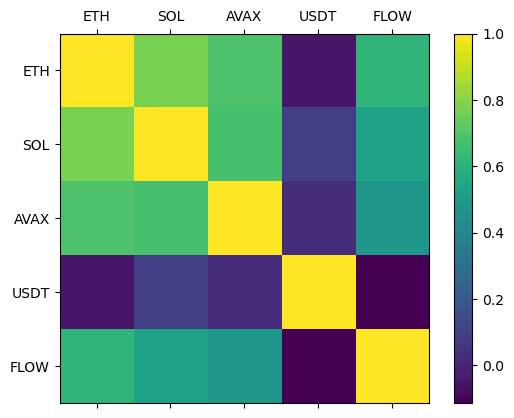

In [7]:
# =============================================================================
# Part 7 & 8, Correlation and plot
# =============================================================================

Corr = dfs_close[[f'close_{tokens[0]}_logreturn', 
                           f'close_{tokens[1]}_logreturn', 
                           f'close_{tokens[2]}_logreturn', 
                           f'close_{tokens[3]}_logreturn', 
                           f'close_{tokens[4]}_logreturn']].corr(method='pearson')

#Print out the correlation matrix
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(Corr)

#Plotting out the correlation

import matplotlib.pyplot as plt

fig = plt.figure()
axis = fig.add_subplot(111)
fig.colorbar(axis.matshow(Corr))

axis.set_xticklabels(['']+tokens)
axis.set_yticklabels(['']+tokens)    
plt.show()